# Ön Bilgi
**Geliştiren :** Onur Kantar - Ömer Resul Ertan

**Veri Kümesi Adı :** Hürriyet

**Veri Kümesinin İçeriği :** 6 farklı sınıfa ait toplamda 6000 haber

**Algoritma :** Convolutional Neural Network (CNN)

**Ağ Mimarisi :** 

- Conv1D(8 x 4)
- Conv1D(4 x 2)
- GlobalMaxPooling1D
- Dense(9)


**batch_size :** 128

**epochs :** 5

**Doğruluk Oranı :** %88


---



In [1]:
import pandas as pd                     
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, SimpleRNN, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Sets/milliyet.csv", sep=';', encoding="ISO-8859–9")
df = df.drop(['ItemID'], axis=1)
df

,Sentiment,SentimentText
0,1,başka dünyanın çocukları 1 ocak sabahından be...
1,1,hepsi nin kızları yerli sevmez mi heygir...
2,1,2009 da ülkemizdeki sağlık harcamaları ve alın...
3,1,laktozsuz sütü kimler içmeli bir bardak süt ...
4,1,2009 trendleri ve içimizdeki alışveriş canavar...
...,...,...
8995,9,h l mı eğer h l bu memlekette kadın erkek ...
8996,9,aşk böceği özellikle haziran ve temmuz ayla...
8997,9,akp karavanı anayasa değişikliği ne getiriyor...
8998,9,boncuk bulma bizim apartmanın içerden ve dış...


# Veri Kümemizi Düzenleyelim : 

---



### NULL Değerleri Silme İşlemi

In [3]:
df.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

In [4]:
# NULL Değer Bulunmuyor.
# df = df.dropna().reset_index(drop=True)
# df.isnull().sum()

### Gereksiz Verileri Kaldıralım  

In [5]:
nltk.download('stopwords')
stop_word_list = stopwords.words('turkish')
stop_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [6]:
def preprocess_text(sen):
    
    # Sayıları Silme İşlemi
    sentence = re.sub('[\d\s]', ' ', str(sen))

    # Noktalama İşaretlerini Silme İşlemi
    sentence = re.sub('[^\w\s]', ' ', str(sentence))
    
    # Tek Karakterleri Silme İşlemi
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    # Birden Çok Boşluğu Silme İşlemi
    sentence = re.sub(r'\s+', ' ', sentence)
        
    # Engellenecek Kelimeleri Silme İşlemi
    WPT = nltk.WordPunctTokenizer()
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)
    
    # Tüm Harfler Küçük Harfe Dönüştürülüyor
    return single_doc.lower()

In [7]:
x = df['SentimentText']
y = df['Sentiment']

In [8]:
x = x.apply(preprocess_text)
pd.DataFrame(data=x)

,SentimentText
0,başka dünyanın çocukları ocak sabahından beri ...
1,nin kızları yerli sevmez mi heygirl dergisinin...
2,ülkemizdeki sağlık harcamaları alınması gereke...
3,laktozsuz sütü kimler içmeli bir bardak süt iç...
4,trendleri içimizdeki alışveriş canavarı yurtdı...
...,...
8995,memlekette kadın erkek eşitliği tartışılıyorsa...
8996,aşk böceği özellikle haziran temmuz aylarının ...
8997,akp karavanı anayasa değişikliği getiriyor çoc...
8998,boncuk bulma bizim apartmanın içerden dışardan...


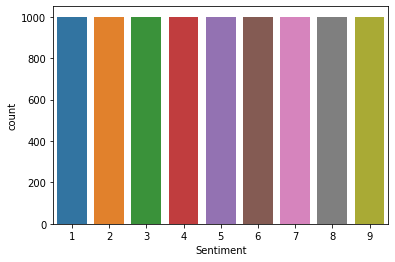

In [9]:
sns.countplot(y)

# X Verilerimizi Düzenleyelim :

## Kelimeleri Sayılara Dönüştürelim

Veri setimizin işlenebilmesi için text verileri numaralara çevirmemiz gerekir.


In [10]:
token = Tokenizer()
# Her kelimenin sıklığını hesaplar
token.fit_on_texts(x)
# Tüm kelimeleri sayı dizisine dönüştürür
x = token.texts_to_sequences(x)
# Bütün metinlerimiz en uzun kelimeden oluşan metnimiz kadar sütundan oluşan (23) bir dizi ile temsil edilecek.
# 23'den kısa metinlerin boşlukları 0'lar ile doldurulacak.
x = pad_sequences(x)

In [11]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559
5116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,14571,8154,824,24,1985,5533,3017,1,13578,1636,54587,14254,824,54,601,5469,1064,32,49031,40,506,6216,610,36,2164,3878,19276,12111,13,137,824,15,16516,13,26040,1437,1931,73933,1378
1777,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,157,1,775,3328,8,1229,6817,8543,396,1,53333,176,28,1129,3428,1506,134,13312,53334,741,9690,14,2987,34598,22,14303,7243,17239,29012,558,25653,1181,4479,125,104804,5867,1,1924,65
5633,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,260,3330,63219,648,60,277,80,121389,853,12466,3636,8747,8,14434,6,842,40604,101,91246,55369,34410,12409,2073,120,60444,2115,7267,119,14,13743,258,29,200214,2,3,3530,65,200215,5465,5123
7920,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12195,973,79,89,2983,194,1173,9662,935,4,10486,7881,11163,123155,7304,224633,39035,68,246,540,462,973,385,5,466,5,1695,42,1580,1268,493,310,51375,245,131,68,24,153,635,5592
4732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,58,4388,257,10504,6556,12,1353,6,4849,15972,43477,3790,257,10504,6556,1826,4106,587,1353,6,4849,11444,257,5000,4373,108,46422,188264,1353,6,42,747,1826,6,37,806,5,6829,2206,3665


## Ölçeklendirelim

**Verileri Ölçeklendirme Nedir?**

Ölçeklendirme dediğimiz şey veri setindeki iki farklı özelliğin (değişkenin) değerlerini en doğru şekilde analiz edebilmemize olanak sağlayan bir yöntemdir.

- Verilerinizin dağılımının ortalama değeri 0 ve standart sapma değeri 1 olacak şekilde değiştiriyoruz (Standartlaştırma).
- Tutarlılık oluşuyor. Bir veri diğer verilerden daha büyükse diğerleri üzerinde egemenlik kurabilir. Bunu istemeyiz.
- Bir öğrenme modeliyle çalışırken, özellikleri sıfır merkezli bir aralığa ölçeklemek önemlidir.
- Değerleri karşılaştırmak yerine oranları karşılaştırmış oluruz.

**Örnek :**

İki farklı insan düşünelim. Bu insanların birisinin geliri ayda 5.000 Türk Lirası iken diğerinin geliri ayda 200.000 Türk Lirası olsun. Bu insanların ikisi de her ay belirli miktarda maddi yardım için maaşlarının bir kısmını ayırıyorlar. Diyelim ki 5.000 Türk Lirası maaşı olan şahıs 1.500 Türk Lirasını yardıma ayırıyorken, 200.000 Türk Lirası alan şahıs 10.000 Türk Lirasını yardım için ayırıyor.

Normal bir gözle bakarsak 10.000 Türk Lirası yardımda bulunan kişinin daha fazla yardım yaptığını görürüz. Fakat bunu oranladığımızda 5.000 Türk Lirası alan kişinin oransal olarak kat kat fazla yardım yaptığı anlaşılacaktır. İşte özellik ölçeklendirme ile biz bu özelliklerin sayısal değerlerinin birbirine yakın olmasını sağlayıp aralarındaki değerleri karşılaştırmak yerine oranları karşılaştırırız.

In [12]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [13]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559
375,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.372347,-0.411070,-0.229387,2.145298,-0.317759,-0.438862,-0.168813,-0.440474,0.573481,-0.442728,-0.447415,-0.269463,-0.311953,-0.425132,-0.268129,-0.400788,-0.351922,-0.356766,-0.370114,-0.424496,-0.350500,-0.360555,-0.434531,-0.160290,-0.439788,-0.390481,-0.392062,-0.432539,-0.370446,-0.437691,-0.415562,-0.310836,0.493736,-0.441405,-0.146938,2.033524,-0.380414,2.024600,-0.395528,-0.458977
4473,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.348882,-0.330461,-0.380043,0.488914,-0.414420,-0.191879,0.864716,-0.439819,-0.438086,-0.435195,-0.407656,-0.216790,-0.313031,-0.423268,-0.179962,-0.230677,-0.314129,0.165994,2.044610,-0.379128,-0.443646,-0.401824,0.630086,-0.423838,4.369932,-0.436684,-0.401551,-0.047090,-0.416735,-0.402664,-0.433389,-0.053225,0.822945,-0.447399,-0.445777,-0.293492,-0.392964,0.891058,-0.221564,-0.125807
6197,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,1.348525,-0.128063,-0.356483,-0.436482,-0.382808,-0.266058,1.867817,-0.441653,0.367697,-0.449112,-0.441388,-0.342495,-0.427557,-0.438150,0.511227,-0.445177,-0.401224,4.989778,-0.353585,-0.439864,-0.259844,-0.072713,-0.361273,-0.441099,-0.442882,-0.436819,-0.440633,-0.399858,0.241920,-0.438109,-0.356877,-0.404167,1.462894,-0.435900,0.331672,0.269451,0.403388,-0.329943,1.140448,-0.519691
3715,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.429006,-0.431579,-0.438176,-0.331785,-0.178234,-0.401638,-0.296458,-0.045136,-0.402457,0.471215,-0.427135,-0.439302,-0.419148,-0.426943,-0.438270,-0.443634,-0.382894,-0.015843,-0.438179,0.578874,-0.413487,-0.371912,-0.426615,-0.352144,0.695630,0.000797,-0.440454,-0.432719,-0.378365,-0.440068,-0.440354,-0.415743,-0.448224,-0.435977,0.463753,-0.301324,-0.439067,-0.439192,-0.375900,-0.475727
6049,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.434025,-0.398195,-0.434452,2.001230,-0.427795,1.621667,0.488794,-0.

## CNN için X'i 3 Boyutlu Hale Getirelim

In [14]:
print('x : ' + str(x.shape))

x : (9000, 3560)


In [15]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
print('x : ' + str(x.shape))

x : (9000, 3560, 1)


# Y Verilerimizi One Hot Encoding Uygulamamız Gerekiyor :  


---


**One Hot Encoding Nedir?**

One Hot Encoding, kategorik değişkenlerin ikili (binary) olarak temsil edilmesi anlamına gelmektedir. Bu işlem, ağın model için problemi daha kolay hale getirmesine yardımcı olabilir. 


- Bu işlem ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir.
- Daha sonra, her bir tamsayı değeri, 1 ile işaretlenmiş tamsayı indeksi dışındaki tüm değerleri   sıfır  olan bir ikili vektör olarak temsil edilir.

In [16]:
pd.DataFrame(y).sample(5)

,Sentiment
2212,3
2890,3
8581,9
8212,9
1479,2


In [17]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
pd.DataFrame(y).sample(5)

,0
4518,4
2808,2
1642,1
859,0
483,0


In [18]:
y = to_categorical(y)
pd.DataFrame(y).sample(5)

,0,1,2,3,4,5,6,7,8
2459,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4823,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5655,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train ve Test İşlemleri İçin Ayrımı Gerçekleştirelim : 

---


In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [20]:
print('x Train : ' + str(x_train.shape))
print('x Test : ' + str(x_test.shape))
print('y Train : ' + str(y_train.shape))
print('y Test : ' + str(y_test.shape))

x Train : (7200, 3560, 1)
x Test : (1800, 3560, 1)
y Train : (7200, 9)
y Test : (1800, 9)


# Katmanları Oluşturup Eğitime Başlayalım : 

---


In [21]:
model = Sequential()

#model.add(Embedding(1000, 20, input_length=3560))

model.add(Conv1D(8, 4, activation='relu', strides=1, input_shape=(x_train.shape[1], 1)))

model.add(Conv1D(4, 2, activation='relu', strides=1))

model.add(GlobalMaxPooling1D())

# model.add(Dense(256, activation = 'relu'))

model.add(Dense(9, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

history = model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data = (x_test, y_test))

Train on 7200 samples, validate on 1800 samples
Epoch 1/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.7186 - acc: 0.6981 - val_loss: 0.6162 - val_acc: 0.7859
Epoch 2/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.5700 - acc: 0.7994 - val_loss: 0.5262 - val_acc: 0.8022
Epoch 3/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.4891 - acc: 0.8002 - val_loss: 0.4517 - val_acc: 0.8012
Epoch 4/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.4287 - acc: 0.8159 - val_loss: 0.4094 - val_acc: 0.8680
Epoch 5/5
7200/7200 [==============================] - 10s 1ms/step - loss: 0.3974 - acc: 0.8874 - val_loss: 0.3866 - val_acc: 0.8891


In [22]:
score = model.evaluate(x_test, y_test, verbose = 0)

In [23]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.3865502074029711
Test accuracy: 0.8890743851661682


# Sonuçları Değerlendirelim

---


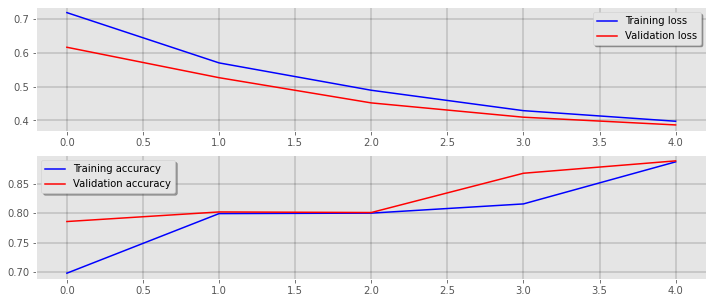

In [24]:
plt.style.use('ggplot')

fig, ax = plt.subplots(2, 1, figsize=(12,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)